In [46]:
!pip install medmnist

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'breastmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download,size=224)
#test_dataset = DataClass(split='test', transform=data_transform, download=download)

#pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
#test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/yuqi/.medmnist/breastmnist_224.npz


In [7]:
print(train_dataset)
print("===================")


Dataset BreastMNIST of size 224 (breastmnist_224)
    Number of datapoints: 546
    Root location: /Users/yuqi/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


# We first compare their singular values

## We first use standard SVD to check their singular values

In [8]:
from sketching_methods.SVD import standard_svd
svd_standards=[]
singular_values=[]
x_train=[]
y_train=[]
for data in train_dataset:
    x,y=data
    x_train.append(np.array(x[0]))
    y_train.append(np.array(y))
    svd_standard,singular_value=standard_svd(x[0])
    svd_standards.append(svd_standard)
    singular_values.append(singular_value)
    

In [9]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [10]:
print(x_train.shape)

(546, 224, 224)


In [11]:
svd_standards=np.array(svd_standards)
singular_values=np.array(singular_values)

## then we try our first sketching matrix

In [11]:
!pip install utils

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com


In [12]:
#we try to do it in another way
import numpy as np
from scipy.linalg import svd
from numpy.linalg import qr

def randomized_svd(A, k, random_matrix,p=5, n_iter=2):
    """
    Perform Randomized SVD on matrix A.
    
    Parameters:
        A: ndarray, shape (m, n)
           Input matrix to decompose.
        k: int
           Target rank (number of singular values/vectors to compute).
        p: int, optional (default=5)
           Oversampling parameter to improve approximation accuracy.
        n_iter: int, optional (default=2)
           Number of iterations for power iteration (improves accuracy).
           
    Returns:
        U: ndarray, shape (m, k)
           Approximated left singular vectors.
        S: ndarray, shape (k,)
           Approximated singular values.
        V: ndarray, shape (k, n)
           Approximated right singular vectors.
    """
    # Step 1: Random sampling
    A=A.astype(np.float64)
    m, n = A.shape
   
    Y = A @ random_matrix

    # Step 2: Power iteration (optional, improves accuracy for ill-conditioned matrices)
    for _ in range(n_iter):
        Y = A @ (A.T @ Y)

    # Step 3: QR decomposition
    Q, _ = qr(Y, mode='reduced')
    

    # Step 4: Project matrix to lower-dimensional space
    B = Q.T @ A

    # Step 5: Compute SVD on the smaller matrix
    U_tilde, S, Vt = svd(B, full_matrices=False)

    # Step 6: Reconstruct the left singular vectors
    U = Q @ U_tilde

    return U[:, :k], S[:k], Vt[:k, :]


## Uniform Sketching Matrices

In [ ]:

from sketching_methods.sketching import uniform_sketching_matrix
Errors_size_uniform=[]
for sketch_size in range(30,170,10):
    uniform_matrices=[]
    for _ in range (len(train_dataset)):
        uniform_matrix=uniform_sketching_matrix(224, sketch_size)
        uniform_matrices.append(uniform_matrix)
    #Turn the matrix into array
    uniform_matrices=np.array(uniform_matrices)
    U_randoms=[]
    S_randoms=[]
    V_randoms=[]
    for i in range(len(train_dataset)):
        U_random,S_random,V_random=randomized_svd(x_train[i],sketch_size,uniform_matrices[i],3)
        U_randoms.append(U_random)
        S_randoms.append(S_random)
        V_randoms.append(V_random)
    #Compute relevant Error
    Errors_uniform=[]
    for i in range(len(train_dataset)):
        approx_uniform=U_randoms[i]@np.diag(S_randoms[i])@V_randoms[i]
        Errors_uniform.append(np.linalg.norm(approx_uniform-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)
#Errors into nparray
    Errors_uniform=np.array(Errors_uniform)
    Errors_size_uniform.append(np.mean(Errors_uniform))


## Gaussian Sketching matrices

In [15]:
from sketching_methods.sketching import gaussian_sketching_matrix
Errors_gaussian_sketch=[]
for sketch_size in range(30,170,10):
    gaussian_matrices=[]
    for i in range (len(train_dataset)):
        gaussian_matrix=gaussian_sketching_matrix(224, sketch_size)
        gaussian_matrices.append(gaussian_matrix)
    gaussian_matrices=np.array(gaussian_matrices)
    # we conduct the same experiment
    U_gaussians=[]
    S_gaussians=[]
    V_gaussians=[]
    for i in range(len(train_dataset)):
        U_gaussian,S_gaussian,V_gaussian=randomized_svd(x_train[i],sketch_size,gaussian_matrices[i],3)
        U_gaussians.append(U_gaussian)
        S_gaussians.append(S_gaussian)
        V_gaussians.append(V_gaussian)
    #turn them into nparray
    U_gaussians=np.array(U_gaussians)
    S_gaussians=np.array(S_gaussians)
    V_gaussians=np.array(V_gaussians)
    #Compute relevant Error
    Errors_gaussian=0
    for i in range(len(train_dataset)):
        approx_gaussian=U_gaussians[i]@np.diag(S_gaussians[i])@V_gaussians[i]
        Errors_gaussian+=np.linalg.norm(approx_gaussian-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2
    Errors_gaussian_sketch.append(Errors_gaussian/546)
    


## Radamecher Sketching Matrices

In [20]:

from sketching_methods.sketching import rademacher_sketch_matrix
errors_sketch_rademacher=[]
for sketch_size in range(30,170,10):
    rademacher_matrices=[]
    for j in range(len(train_dataset)):
        rademacher_matrix=rademacher_sketch_matrix(224, sketch_size)
        rademacher_matrices.append(rademacher_matrix)
    rademacher_matrices=np.array(rademacher_matrices)
    # we conduct the same experiment
    U_rademachers=[]
    S_rademachers=[]
    V_rademachers=[]
    for i in range(len(train_dataset)):
        U_rademacher,S_rademacher,V_rademacher=randomized_svd(x_train[i],sketch_size,rademacher_matrices[i],3)
        U_rademachers.append(U_rademacher)
        S_rademachers.append(S_rademacher)
        V_rademachers.append(V_rademacher)
    U_rademachers=np.array(U_rademachers)
    S_rademachers=np.array(S_rademachers)
    V_rademachers=np.array(V_rademachers)
    #Compute relevant Error
    Errors_rademacher=0
    for i in range(len(train_dataset)):
        approx_rademacher=U_rademachers[i]@np.diag(S_rademachers[i])@V_rademachers[i]
        Errors_rademacher+=np.linalg.norm(approx_rademacher-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2
    errors_sketch_rademacher.append(Errors_rademacher/546)
    

## Johnson-Linderstrauss Transform Code

In [19]:

import sys
import os
sys.path.append(os.path.abspath('.'))

from sketching_methods.jlt.linearMapping import calculate_R
errors_JLT_sketch=[]
for sketch_size in range(30,170,10):
    JLT_matrices=[]
    for i in range(len(train_dataset)):
        JLT_matrix=calculate_R(224,k=sketch_size,s=1,random_seed=21,swr=True)
        JLT_matrices.append(JLT_matrix)
    #Turn it into arrays
    JLT_matrices=np.array(JLT_matrices)
    # we conduct the same experiment to do random SVD
    U_JLTs=[]
    S_JLTs=[]
    V_JLTs=[]
    for i in range(len(train_dataset)):
        U_JLT,S_JLT,V_JLT=randomized_svd(x_train[i],sketch_size,JLT_matrices[i].toarray().T,3)
        U_JLTs.append(U_JLT)
        S_JLTs.append(S_JLT)
        V_JLTs.append(V_JLT)
    U_JLTs=np.array(U_JLTs)
    S_JLTs=np.array(S_JLTs)
    V_JLTs=np.array(V_JLTs)
    #Compute relevant Error
    Errors_JLT=0
    for i in range(len(x_train)):
        approx_JLT=U_JLTs[i]@np.diag(S_JLTs[i])@V_JLTs[i]
        Errors_JLT+=np.linalg.norm(approx_JLT-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2
    #Turn it into an array
    errors_JLT_sketch.append(Errors_JLT/546)


## Clarkson_Woodruff

In [22]:
from sketching_methods.sketching import cwt_sketch_matrix
Errors_cwt_sketch=[]
for sketch_size in range(30,170,10):
    cwt_sketch_matrices=[]
    for _ in range(len(train_dataset)):
        cwt_matrix=cwt_sketch_matrix(224,sketch_size,rng=None)
        cwt_sketch_matrices.append(cwt_matrix)
    # we conduct the same experiment to do random SVD
    U_cwts=[]
    S_cwts=[]
    V_cwts=[]
    for i in range(len(train_dataset)):
        U_cwt,S_cwt,V_cwt=randomized_svd(x_train[i],sketch_size,cwt_sketch_matrices[i],3)
        U_cwts.append(U_cwt)
        S_cwts.append(S_cwt)
        V_cwts.append(V_cwt)
    U_cwts=np.array(U_cwts)
    S_cwts=np.array(S_cwts)
    V_cwts=np.array(V_cwts)
    #Compute Relative Error
    Errors_cwt=0
    for i in range(len(train_dataset)):
        approx_cwt=U_cwts[i]@np.diag(S_cwts[i])@V_cwts[i]
        Errors_cwt+=np.linalg.norm(approx_cwt-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2
    Errors_cwt_sketch.append(Errors_cwt/546)

## SRFT Transform

In [24]:
#SJLT Transform

from sketching_methods.sketching  import sparse_sign_embedding_sketch_matrix
Errors_SRFT_sketch=[]
for sketch_size in range(30,170,10):
    SRFT_matrices=[]
    for _ in range(len(train_dataset)):
        SRFT_matrix=sparse_sign_embedding_sketch_matrix(sketch_size,224)
        SRFT_matrices.append(SRFT_matrix)
    SRFT_matrices=np.array(SRFT_matrices)
    U_SRFTs=[]
    S_SRFTs=[]
    V_SRFTs=[]
    for i in range(len(train_dataset)):
        U_SRFT,S_SRFT,V_SRFT=randomized_svd(x_train[i],sketch_size,SRFT_matrices[i].T,3)
        U_SRFTs.append(U_SRFT)
        S_SRFTs.append(S_SRFT)
        V_SRFTs.append(V_SRFT)
    U_SRFTs=np.array(U_SRFTs)
    S_SRFTs=np.array(S_SRFTs)
    V_SRFTs=np.array(V_SRFTs)
    #Compute Relative Error
#Compute Relative Error
    Errors_SRFTs=0
    for i in range(len(train_dataset)):
        approx_SRFT=U_SRFTs[i]@np.diag(S_SRFTs[i])@V_SRFTs[i]
        Errors_SRFTs+=np.linalg.norm(approx_SRFT-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2
    Errors_SRFT_sketch.append(Errors_SRFTs/546)
    
    


## Hadarmard Transform


# Visualization

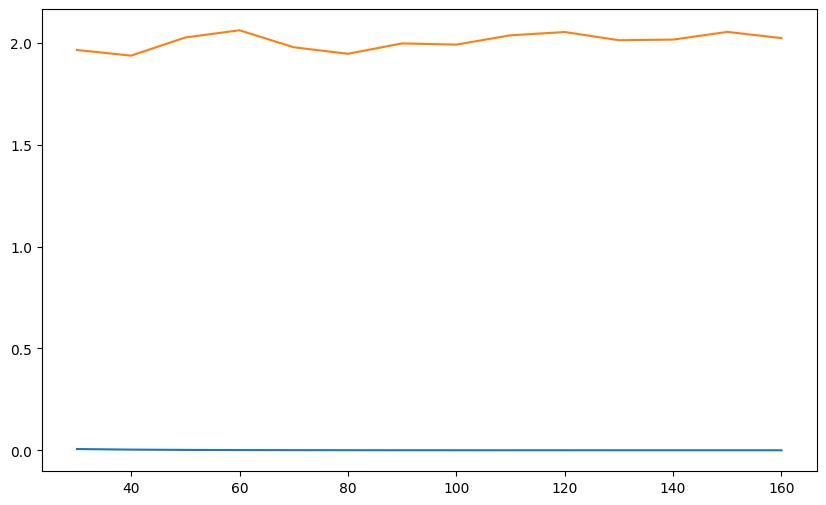

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(30,170,10), Errors_gaussian_sketch, label='gaussian')
plt.plot(range(30,170,10), Errors_SRFT_sketch, label='SRFT')

## Standard SVD

In [47]:
# Let's check their condition number
Condition_number=[]
result_svd=[]
for i in range(len(x_train)):
    S,V,D=svd(x_train[i],full_matrices=False)
    approx_svd=S[:,:12]@np.diag(V[:12])@D[:12,:]
    result_svd.append(approx_svd)
    condition=V[0]/V[-1]
    Condition_number.append(condition)

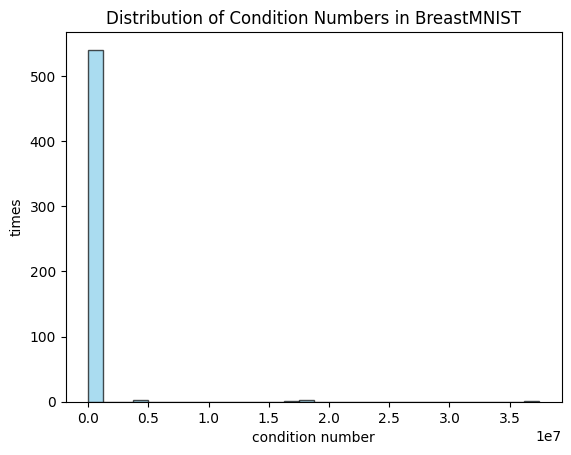

In [18]:
plt.hist(Condition_number, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.title('Distribution of Condition Numbers in BreastMNIST')
plt.xlabel('condition number')
plt.ylabel('times')

# 显示图形
plt.show()


In [50]:
print('mean',np.mean(Condition_number))
print('median',np.median(Condition_number))         # 中位数
print('std',np.std(Condition_number))           # 标准差
print('var',np.var(Condition_number))          # 方差
print('min',np.min(Condition_number))           # 最小值
print('max',np.max(Condition_number))           # 最大值
print('percentile',np.percentile(Condition_number, [25, 50, 75]))  # 四分位数

mean 214174.42
median 7550.501
std 2092977.5
var 4380555000000.0
min 647.31476
max 37453104.0
percentile [ 3532.62408447  7550.50073242 19286.70947266]


In [20]:
np.min(Condition_number)

647.31476

In [21]:
np.max(Condition_number)

37453104.0